## Анализ результатов АБ-теста

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

import scipy
from statsmodels.sandbox.stats.multicomp import multipletests 

### В данном задании вам нужно будет

- проанализировать АБ тест, проведенный на реальных пользователях Яндекса
- подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной ($control$) и тестовой ($exp$) группами
- определить характер этих изменений и практическую значимость вводимого изменения
- понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)

### Описание данных:

- userID: уникальный идентификатор пользователя
- browser: браузер, который использовал userID
- slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
- n_clicks: количество кликов, которые пользоваль совершил за n_queries
- n_queries: количество запросов, который совершил userID, пользуясь браузером browser
- n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце $userID$ есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание $userID$ и $browser$.

Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

In [2]:
browser = pd.read_csv('browser.csv')
browser.shape

(566134, 6)

In [3]:
browser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566134 entries, 0 to 566133
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   userID            566134 non-null  int64 
 1   browser           566134 non-null  object
 2   slot              566134 non-null  object
 3   n_clicks          566134 non-null  int64 
 4   n_queries         566134 non-null  int64 
 5   n_nonclk_queries  566134 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 25.9+ MB


In [4]:
browser.describe()

,userID,n_clicks,n_queries,n_nonclk_queries
count,566134.000000,566134.000000,566134.000000,566134.000000
mean,301377.214027,11.431658,10.720524,4.703987
std,175526.333101,20.251494,16.262827,8.109958
min,1.000000,0.000000,1.000000,0.000000
25%,148627.250000,1.000000,2.000000,1.000000
50%,299362.500000,4.000000,5.000000,2.000000
75%,455698.750000,13.000000,13.000000,6.000000
max,603137.000000,863.000000,665.000000,581.000000


In [5]:
browser.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


#### 1. Посчитайте, насколько в группе $exp$ больше пользовательских кликов по сравнению с группой $control$ в процентах от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки. 

In [6]:
exp = browser[browser.slot == 'exp']
control = browser[browser.slot == 'control']

exp_clicks_total = exp.n_clicks.sum()
control_clicks_total = control.n_clicks.sum()

proportion_clicks = (exp_clicks_total / control_clicks_total - 1) * 100
print(f'Increase of click proportion for exp group by {proportion_clicks:.3f}% of control group clicks')

Increase of click proportion for exp group by 1.614% of control group clicks


#### 2. Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп.

In [7]:
def get_bootstrap_samples(data, n_samples):    
    # n_samples -> inf --> better precision    
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def conf_int(sample, alpha=0.05):
    boundaries = np.percentile(sample, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

exp_mean = exp.n_clicks.mean()
control_mean = control.n_clicks.mean()

print(f'Mean number of clicks for exp: {exp_mean:.4f}')
print(f'Mean number of clicks for control: {control_mean:.4f}')

exp_median = exp.n_clicks.median()
control_median = control.n_clicks.median()

print(f'Median number of clicks for exp: {exp_median}')
print(f'Median number of clicks for control: {control_median}')

Mean number of clicks for exp: 11.5840
Mean number of clicks for control: 11.2809
Median number of clicks for exp: 5.0
Median number of clicks for control: 4.0


95% confidence interval for n_clicks of mean difference: [0.21295518 0.40644326]
95% confidence interval for n_clicks of median difference: [1. 1.]
CPU times: user 12.6 s, sys: 1.31 s, total: 13.9 s
Wall time: 13.6 s


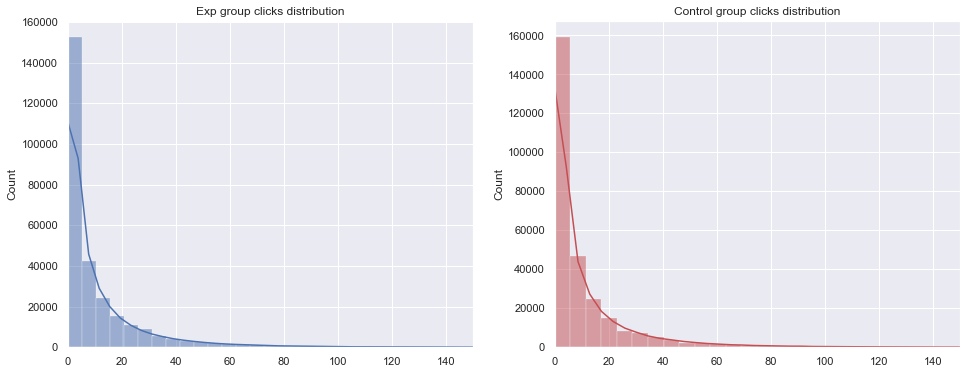

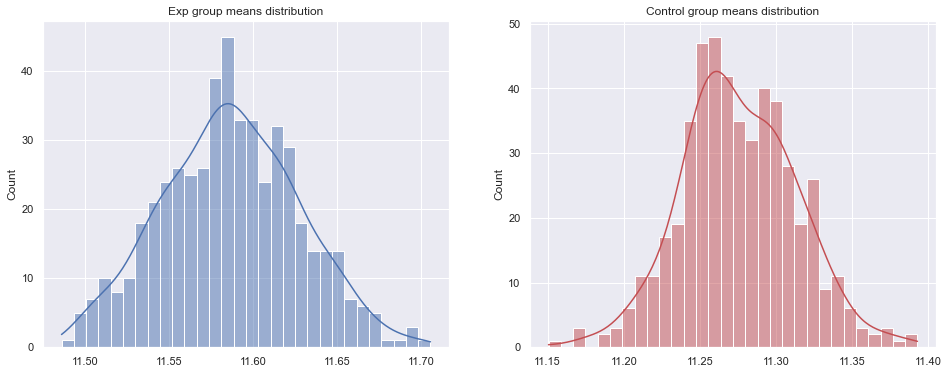

In [8]:
%%time

exp_clicks = exp.n_clicks.values
control_clicks = control.n_clicks.values

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.histplot(exp_clicks, bins=150, kde=True)
plt.xlim(0, 150)
plt.title('Exp group clicks distribution')
plt.subplot(1,2,2)
sns.histplot(control_clicks, bins=150, color='r', kde=True)
plt.xlim(0, 150)
plt.title('Control group clicks distribution')

exp_samples = get_bootstrap_samples(exp_clicks, 500)
control_samples = get_bootstrap_samples(control_clicks, 500)

exp_means = np.array([np.mean(sample) for sample in exp_samples])
exp_medians = np.array([np.median(sample) for sample in exp_samples])
control_means = np.array([np.mean(sample) for sample in control_samples])
control_medians = np.array([np.median(sample) for sample in control_samples])

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.histplot(exp_means, bins=30, kde=True)
plt.title('Exp group means distribution')
plt.subplot(1,2,2)
sns.histplot(control_means, color='r', bins=30, kde=True)
plt.title('Control group means distribution')

diff_means = exp_means - control_means
diff_medians = exp_medians - control_medians

conf_int_means = conf_int(diff_means)
conf_int_medians = conf_int(diff_medians)

print(f'95% confidence interval for n_clicks of mean difference: {conf_int_means}')
print(f'95% confidence interval for n_clicks of median difference: {conf_int_medians}')

#### 3-4. Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных.

Для простоты рассмотрим одновыборочный t-критерий. Его статистика имеет вид: $\frac{\bar{X} - \mu}{ \sqrt {S^2 / n}}$

То есть чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

- $\bar{X}$ — среднее значение в выборке — было распределено нормально $N(\mu,\frac{\sigma^2}{n})$
- $\frac{nS^2}{\sigma^2}$ — несмещенная оценка дисперсии c масштабирующим коэффициентом — была распределена по хи-квадрат c n−1 степенями свободы $\chi^2(n−1)$ 

Простое доказательство необходимости и достаточности этого требования можно посмотреть в самом последнем абзаце этого вопроса. Усвоение этого доказательства не обязательно для выполнения задания.

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого:

1. Получите из данных n_boot_samples псевдовыборок.
1. По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared)
1. Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью <code>scipy.stats.probplot</code> для нормального распределения
1. Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью <code>scipy.stats.probplot</code> для хи-квадрат распределения с помощью команды:
<center><code>scipy.stats.probplot(control_boot_chi_squared, dist="chi2", sparams=(n-1), plot=plt)</code></center>

Где $sparams=(n-1)$ означают число степеней свободы = длине выборки - 1.

Чтобы получить такой же ответ, как у нас, зафиксируйте seed и количество псевдовыборок: 

<center><code>np.random.seed(0)<br>n_boot_samples = 500</code></center>

В качестве ответа отметьте верные утвердения о значениях $R^2$, которые генерирует <code>scipy.stats.probplot</code> при отображении qq-графиков: одно c графика для среднего и одно с графика для выборочной суммы квадратов отклонения от выборочной суммы.

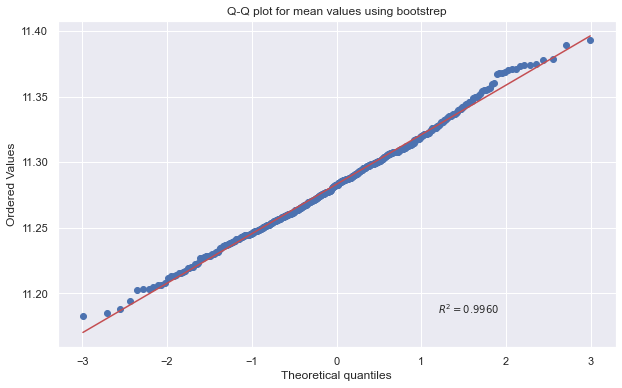

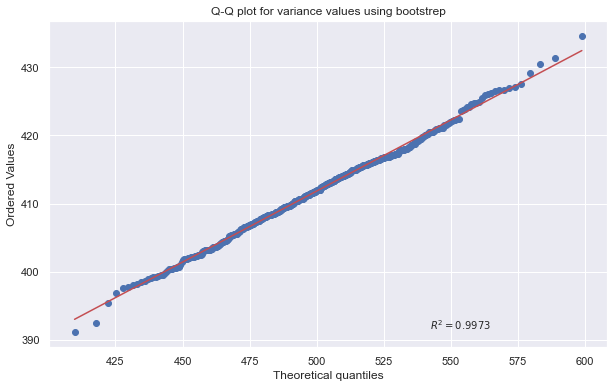

CPU times: user 4.72 s, sys: 613 ms, total: 5.33 s
Wall time: 6.4 s


In [9]:
%%time

np.random.seed(0)
n_boot_samples = 500

control_samples = get_bootstrap_samples(control_clicks, n_boot_samples)

control_boot_means = np.array([np.mean(sample) for sample in control_samples])
control_boot_chi_squared = np.array([np.var(sample) for sample in control_samples])

n = control_samples.shape[0]

plt.figure(figsize=(10,6))
scipy.stats.probplot(control_boot_means, plot=plt, rvalue=True)
plt.title('Q-Q plot for mean values using bootstrep')
plt.show()

plt.figure(figsize=(10,6))
scipy.stats.probplot(control_boot_chi_squared, dist='chi2', sparams=(n-1), plot=plt, rvalue=True)
plt.title('Q-Q plot for variance values using bootstrep')
plt.show()

#### 5. Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости?

In [10]:
scipy.stats.mannwhitneyu(exp_clicks, control_clicks, alternative='two-sided')

MannwhitneyuResult(statistic=41184125116.0, pvalue=6.247235801369629e-75)

Согласно статистическому тесту Манна-Уитни о равенстве средних мы вынуждены отвергнуть нулевую гипотезу $H_0$, p-value ~ 0

#### 6. Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с $\alpha=0.05$.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [11]:
unique_browsers = np.unique(browser['browser'])
unique_browsers

array(['Browser #14', 'Browser #17', 'Browser #2', 'Browser #20',
       'Browser #22', 'Browser #4'], dtype=object)

In [12]:
browser_clicks_exp = exp.groupby(['browser', 'userID']).sum().n_clicks
browser_clicks_ctrl = control.groupby(['browser', 'userID']).sum().n_clicks

p_values = []

for index, name in enumerate(unique_browsers):
    stat, p_value = scipy.stats.mannwhitneyu(
        browser_clicks_exp[name], browser_clicks_ctrl[name], alternative='two-sided')
    
    p_values.append(p_value)
    print(f'{name}: p-value = {p_value:.4f}')
    
count_unsign_before = sum(p > 0.05 for p in p_values)
print(f'Number of statistically unsignificant p-values > 0.05 before correction: {count_unsign_before}')

Browser #14: p-value = 0.0000
Browser #17: p-value = 0.0748
Browser #2: p-value = 0.0545
Browser #20: p-value = 0.9073
Browser #22: p-value = 0.5148
Browser #4: p-value = 0.8152
Number of statistically unsignificant p-values > 0.05 before correction: 5


In [13]:
# Holm correction
reject_1, p_holm, a1_1, a2_1 = multipletests(p_values, alpha=0.05, method='holm')
print('P-values after Holm correction:\n', np.array(p_holm))

# Bonferroni correction
reject_2, p_holm_bonf, a1_2, a2_2 = multipletests(p_holm, method='bonferroni')
print('P-values after Holm-Bonferroni correction:\n', np.array(p_holm_bonf))
                                                               
# Count statistically unsignificant p > 0.05 before holm-bonferroni correction
count_unsign = sum(p > 0.05 for p in p_holm_bonf)
print(f'Number of statistically unsignificant p-values > 0.05 after correction: {count_unsign}')

P-values after Holm correction:
 [0.         0.29920481 0.2724386  1.         1.         1.        ]
P-values after Holm-Bonferroni correction:
 [0. 1. 1. 1. 1. 1.]
Number of statistically unsignificant p-values > 0.05 after correction: 5


#### 7. Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ? 

In [14]:
exp.groupby(['browser']).sum()

,userID,n_clicks,n_queries,n_nonclk_queries
browser,,,,
Browser #14,14903639817,294556,282606,123656
Browser #17,4624596106,266285,210123,77614
Browser #2,16998146364,560109,548019,246514
Browser #20,4896313412,223212,187283,72998
Browser #22,21217798358,858666,743156,296177
Browser #4,22195973421,1058995,1011250,456508


In [15]:
control.groupby(['browser']).sum()

,userID,n_clicks,n_queries,n_nonclk_queries
browser,,,,
Browser #14,15167527449,207229,279998,161252
Browser #17,4688717420,266732,208921,75837
Browser #2,17275496449,565964,566239,260259
Browser #20,4971658893,225897,193752,78548
Browser #22,21382390812,879810,777135,315470
Browser #4,22297629185,1064395,1060771,498254


In [16]:
nonclk_queries_exp = exp.groupby(['browser']).sum().n_nonclk_queries
n_queries_exp = exp.groupby(['browser']).sum().n_queries
never_click_exp = nonclk_queries_exp * 100 / n_queries_exp

nonclk_queries_control = control.groupby(['browser']).sum().n_nonclk_queries
n_queries_control = control.groupby(['browser']).sum().n_queries
never_click_control = nonclk_queries_control * 100 / n_queries_control

for index, name in enumerate(unique_browsers):
    print(f'{name} - Exp: {never_click_exp.loc[name]:.4f}%, Control: {never_click_control.loc[name]:.4f}%')

Browser #14 - Exp: 43.7556%, Control: 57.5904%
Browser #17 - Exp: 36.9374%, Control: 36.2994%
Browser #2 - Exp: 44.9827%, Control: 45.9627%
Browser #20 - Exp: 38.9774%, Control: 40.5405%
Browser #22 - Exp: 39.8539%, Control: 40.5940%
Browser #4 - Exp: 45.1429%, Control: 46.9709%
